In [1]:
import cv2
import pandas as pd
import random
import os 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data_path = "data\\chest_xray"
train_path = os.path.join(data_path, "train")
train_path_normal = os.path.join(data_path, "train\\NORMAL")
train_path_pneumonia = os.path.join(data_path, "train\\PNEUMONIA")
test_path = os.path.join(data_path, "test")
val_path = os.path.join(data_path, "val")


## EDA (Exploratory Data Analysis)

In [3]:
for dataset_type in ["train", "test", "val"]:
    for category in ["NORMAL", "PNEUMONIA"]:
        path = os.path.join(data_path, dataset_type, category)
        print(f"{dataset_type} - {category}: {len(os.listdir(path))} images")

train - NORMAL: 1341 images
train - PNEUMONIA: 3875 images
test - NORMAL: 234 images
test - PNEUMONIA: 390 images
val - NORMAL: 8 images
val - PNEUMONIA: 8 images


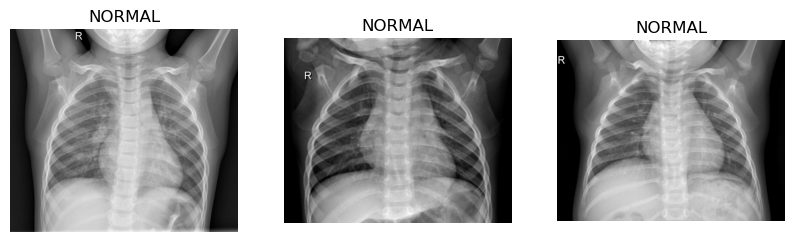

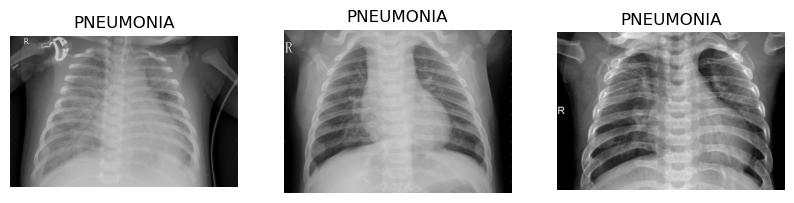

In [4]:
def plot_images(category, dataset_type, num_images=3):
    path = os.path.join(data_path, dataset_type, category)
    images = os.listdir(path)[:num_images]
    plt.figure(figsize=(10, 10))
    for i, img_name in enumerate(images):
        img = Image.open(os.path.join(path, img_name))
        plt.subplot(1, num_images, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{category}")
        plt.axis('off')
    plt.show()

plot_images("NORMAL", "train")
plot_images("PNEUMONIA", "train")

**High-intensity abnormal areas**: In the MRI of a patient with pneumonia, there are areas that appear brighter (due to inflammation or fluid) compared to the image of a normal patient, where the lungs appear dark.

**Consolidations and opacities**: Pulmonary consolidation areas, which are regions where the alveoli are filled with fluid and inflammatory cells, are not present in a healthy patient.

**Changes in lung structure**: The appearance of pulmonary edema and thickening of the bronchi and pleura is a typical indicator of infection in MRI images 
of a patient with pneumonia.

**Pleural effusion**: If the infection is severe, a pleural effusion (accumulation of fluid between the two layers of the pleura) may be observed, which is not normal.

In [5]:
def load_images_from_path(path, grayscale=True):
    """
    Charge les images présentes dans un répertoire donné et les stocke dans une liste.
    
    Parameters:
        path (str): Le chemin du répertoire contenant les images.
        grayscale (bool): Si True, charge les images en niveaux de gris.
        
    Returns:
        list: Une liste contenant toutes les images chargées et redimensionnées.
    """
    images = []
    
    if not os.path.exists(path):
        raise FileNotFoundError(f"The specified path '{path}' does not exist.")
    
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        
        if os.path.isfile(file_path):
            if grayscale:
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            else:
                image = cv2.imread(file_path, cv2.IMREAD_COLOR)
            if image is not None:
                images.append(image)
    return images

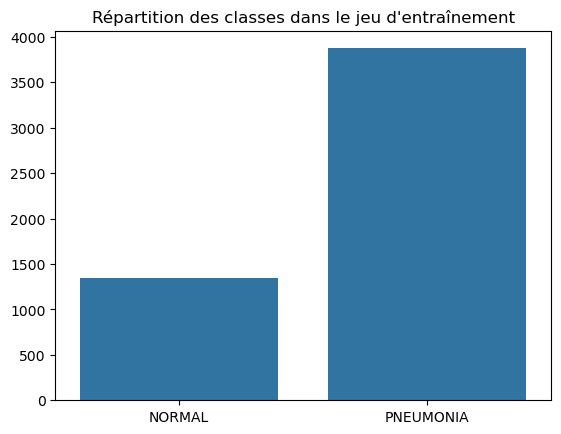

In [6]:
train_counts = {'NORMAL': len(os.listdir(os.path.join(train_path, 'NORMAL'))),
                'PNEUMONIA': len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))}

sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Répartition des classes dans le jeu d'entraînement")
plt.show()


We can observe that the class distribution is not balanced, which could potentially impact the performance of the machine learning model. Therefore, we will proceed to resample the dataset to address this imbalance in the next sections of this notebook.

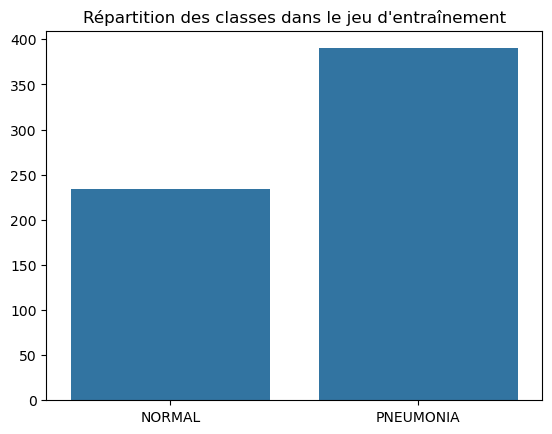

In [7]:
train_counts = {'NORMAL': len(os.listdir(os.path.join(test_path, 'NORMAL'))),
                'PNEUMONIA': len(os.listdir(os.path.join(test_path, 'PNEUMONIA')))}

sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Répartition des classes dans le jeu d'entraînement")
plt.show()


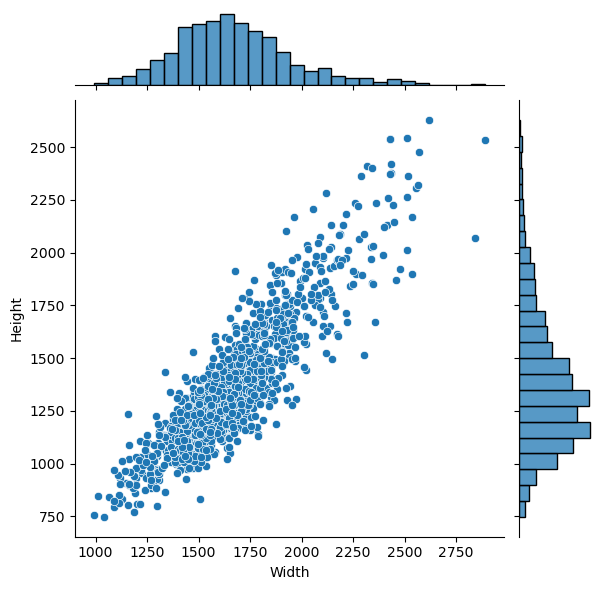

In [8]:
image_shapes = []

#for category in ["NORMAL", "PNEUMONIA"]:
path = os.path.join(train_path, "NORMAL")
for img_name in os.listdir(path)[:1000]:  
    img = Image.open(os.path.join(path, img_name))
    image_shapes.append(img.size)

df_shapes = pd.DataFrame(image_shapes, columns=["Width", "Height"])
sns.jointplot(x="Width", y="Height", data=df_shapes, kind="scatter")
plt.show()

The graph above reveals variations in the dimensions of the images within the dataset. Standardizing the image dimensions is essential before proceeding with the training phase.

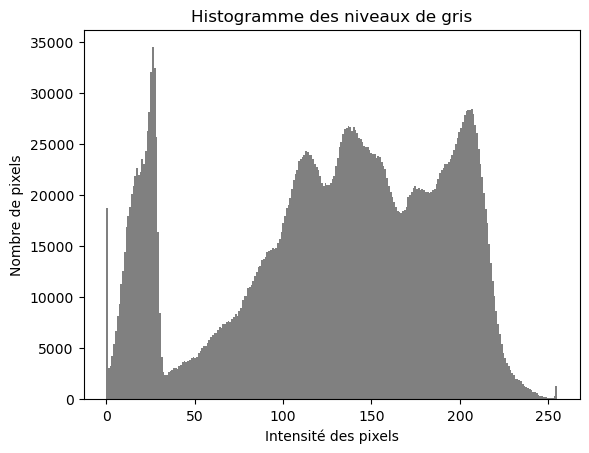

In [9]:
def plot_histogram(img_path):
    img = Image.open(img_path).convert("L")
    img_array = np.array(img)
    plt.hist(img_array.ravel(), bins=256, color='gray')
    plt.title("Histogramme des niveaux de gris")
    plt.xlabel("Intensité des pixels")
    plt.ylabel("Nombre de pixels")
    plt.show()

plot_histogram(os.path.join(train_path, "NORMAL", os.listdir(os.path.join(train_path, "NORMAL"))[0]))

The histogram represents the distribution of grayscale levels in an image. The horizontal axis represents pixel intensity (0 = black, 255 = white).The vertical axis indicates the number of pixels for each intensity level.
It is importnat to note that a significant peak in the darker tones (low pixels intensity) may indicate low contrast or a lighting issue in the image.

## Data Preparation

### Data Standardization

#### 1-Naive Standardization

The objectif is to prepare chest X-ray images for analysis by ensuring they all have the same dimensions (256x256 pixels). This standardization is essential for consistent input to machine learning models or image processing tasks.

In [10]:
# Loading images
# images_train_normal = load_images_from_path(train_path_normal)
# images_train_pneumonia = load_images_from_path(train_path_pneumonia) 

Standardizing image resolutions to a fixed size, like 256×256 is common in image processing and machine learning because it simplifies model input requirements. However, resizing can indeed lead to undesirable effects, such as:

**Blurriness**: When images are upscaled significantly, the interpolation can introduce blurring.

**Loss of Detail**: Downscaling may remove important features in the image, which can negatively impact model performance.

**Aspect Ratio Distortion**: If the original aspect ratio isn't preserved during resizing, it can distort the content of the image.

Solution --> Preserving Aspect Ratio.

Instead of forcing all images to 256×256 pixels, resize them so that the shorter side matches 256 while maintaining the aspect ratio. Then, pad the remaining space with black (zero) pixels to make the final dimensions 256×256.

#### 2-Resizing to 1024x1024 resolution while keeping aspect ratio

In [11]:
def resize_with_padding(image, target_size):
    """
    Resize an image while preserving its aspect ratio and pad the remaining space with black pixels.
    
    Parameters:
        image (numpy array): The input image to resize.
        target_size (int): The desired size for both width and height of the output image.
    
    Returns:
        numpy array: The resized and padded image.
    """
    h, w = image.shape[:2]
    scale = target_size / max(h, w)  # Scale factor to resize while preserving aspect ratio
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Resize the image
    resized = cv2.resize(image, (new_w, new_h))
    
    # Calculate padding
    delta_w = target_size - new_w
    delta_h = target_size - new_h
    top, bottom = delta_h // 2, delta_h - delta_h // 2
    left, right = delta_w // 2, delta_w - delta_w // 2
    
    # Add padding to make the image square
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded

# Standardizing image dimensions with padding
#target_size = 1024  # Desired size (width and height)

#images_train_normal_resized_1024 = [resize_with_padding(image, target_size) for image in images_train_normal]
#images_train_pneumonia_resized_1024 = [resize_with_padding(image, target_size) for image in images_train_pneumonia]

# print(len(images_train_normal_resized_1024), len(images_train_pneumonia_resized_1024))


### Data Resampling


To address the class imbalance observed in the training and validation datasets, where pneumonia cases are overrepresented, it is important to choose between undersampling (reducing pneumonia images) and oversampling (increasing normal images). To avoid information loss that could negatively impact the machine learning model's performance, oversampling is the preferred approach in this case. This can be achieved by duplicating images from the normal class or applying data augmentation techniques. Data augmentation will be applied automatically using the keras function ImageDataGenrator further in the notebook. 

## Modelisation 

The input data for a Convolutional Neural Network (CNN) should consist of preprocessed images that are formatted to match the model's expected input dimensions. These images can be in grayscale (common for medical imaging like chest X-rays) or RGB, depending on the application. Each image must be resized to a uniform size, such as 256x256 pixels, to ensure consistency across the dataset. Pixel values should be normalized to a range of [0, 1] by dividing by 255 to improve model convergence during training. For grayscale images, an additional channel dimension is added, resulting in an input shape of (height, width, 1). Additionally, the dataset should be balanced across classes, and labels should be one-hot encoded if the task is a classification problem. Proper preprocessing ensures that the CNN can effectively extract meaningful features from the images. 
The input data for a Convolutional Neural Network (CNN) should be in the form of numerical arrays, typically as a NumPy array. While the raw images are often stored as files in formats like JPEG, PNG, or DICOM, they need to be converted into numerical arrays before being fed into the CNN. 

In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data preprocessing with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_path,
    color_mode="grayscale",
    batch_size=32,
    class_mode="binary",
    target_size=(256, 256)
)

val_data = val_datagen.flow_from_directory(
    val_path,
    color_mode="grayscale",
    batch_size=32,
    class_mode="binary",
    target_size=(256, 256)
)

test_data = test_datagen.flow_from_directory(
    test_path,
    color_mode="grayscale",
    batch_size=32,
    class_mode="binary",
    target_size=(256, 256)
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [37]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Custom model class
class PneumoniaModel:
    def __init__(self, input_shape=(256, 256, 1), num_classes=1):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None

    def build_model(self):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=self.input_shape),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(256, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(self.num_classes, activation="sigmoid")  # Use "sigmoid" for binary classification
        ])

    def summary(self):
        if self.model is not None:
            self.model.summary()
        else:
            raise ValueError("Model is not built yet. Call `build_model()` first.")

    def compile(self):
        self.model.compile(
            optimizer="adam",
            loss="binary_crossentropy",  # Use "binary_crossentropy" for binary classification
            metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.AUC()]
        )

    def fit(self, train_data, epochs, validation_data=None):
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=3),
            ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
        ]
        history = self.model.fit(
            train_data,
            epochs=epochs,
            validation_data=validation_data,
            callbacks=callbacks
        )
        return history

    def evaluate(self, test_data):
        loss, recall, precision, auc = self.model.evaluate(test_data)
        print(f"Test Loss: {loss:.4f}")
        print(f"Test Recall: {recall:.4f}")
        print(f"Test Precision: {precision:.4f}")
        print(f"Test AUC: {auc:.4f}")
        return loss, recall, precision, auc

    def predict(self, test_data):
        predictions = self.model.predict(test_data)
        return predictions

In [42]:
model = PneumoniaModel()
model.build_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 30, 30, 128)      

In [43]:
model.compile()

In [ ]:
history = model.fit(train_data, epochs=20, validation_data=val_data)

Epoch 1/20
 73/163 [============>.................] - ETA: 3:16 - loss: 0.5406 - recall_2: 0.9942 - precision_1: 0.7414 - auc_1: 0.6420

In [34]:
model.evaluate(test_data)

20/20 [==============================] - 14s 665ms/step - loss: 0.8326 - recall: 0.7468
Test Loss: 0.8326
Test Accuracy: 0.7468


In [35]:
predictions = model.predict(test_data)

20/20 [==============================] - 14s 622ms/step
Prediction is : [[0.00969755 0.9903024 ]
 [0.01299003 0.98701   ]
 [0.01406935 0.9859307 ]
 ...
 [0.01573487 0.9842651 ]
 [0.00846215 0.9915379 ]
 [0.00165526 0.9983448 ]]


1/1 [==============================] - 1s 737ms/step
Prediction is : [[6.33250058e-01 3.66749883e-01]
 [4.54597728e-04 9.99545395e-01]
 [1.40842581e-02 9.85915780e-01]
 [9.70152020e-03 9.90298450e-01]
 [1.29900342e-02 9.87010002e-01]
 [1.44085601e-01 8.55914354e-01]
 [9.22889914e-03 9.90771055e-01]
 [3.51815447e-02 9.64818418e-01]
 [1.44764865e-02 9.85523582e-01]
 [4.90790069e-01 5.09209991e-01]
 [7.92198718e-01 2.07801268e-01]
 [1.00660017e-02 9.89934027e-01]
 [6.70438074e-03 9.93295610e-01]
 [4.04188260e-02 9.59581196e-01]
 [9.63431885e-05 9.99903679e-01]
 [1.39393406e-02 9.86060619e-01]
 [1.01687359e-02 9.89831269e-01]
 [6.40159786e-01 3.59840155e-01]
 [2.15774197e-02 9.78422582e-01]
 [9.71766748e-03 9.90282297e-01]
 [1.16808601e-02 9.88319159e-01]
 [6.68816781e-03 9.93311882e-01]
 [7.55835652e-01 2.44164318e-01]
 [1.18891811e-02 9.88110781e-01]
 [7.46355345e-03 9.92536426e-01]
 [1.36554092e-02 9.86344576e-01]
 [9.42953490e-03 9.90570426e-01]
 [1.00599919e-02 9.89939988e-01]
 [2.184

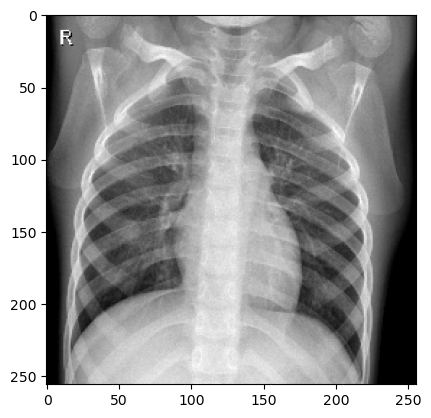

The prediction related to this image is :  NORMAL
 The true label of this image is : NORMAL


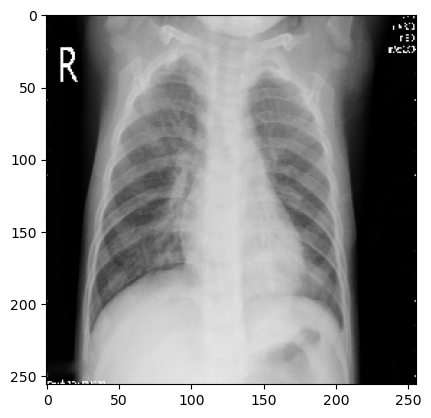

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


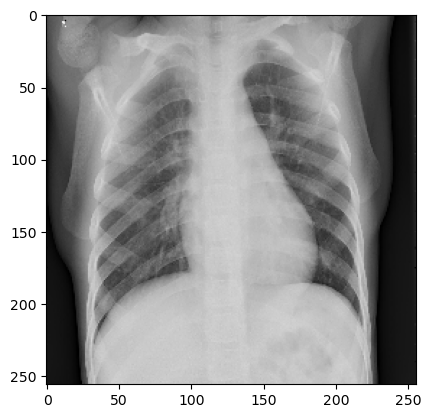

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : NORMAL


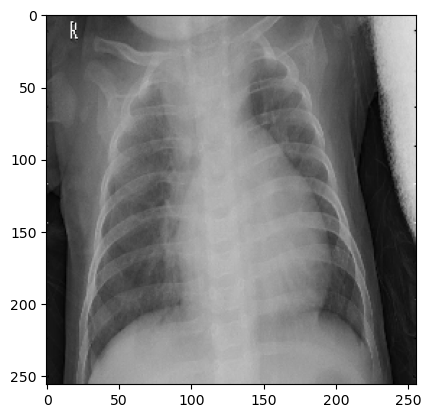

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


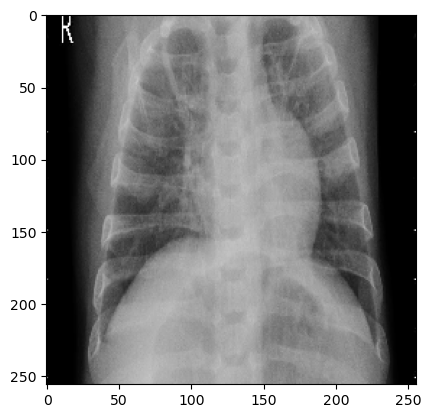

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


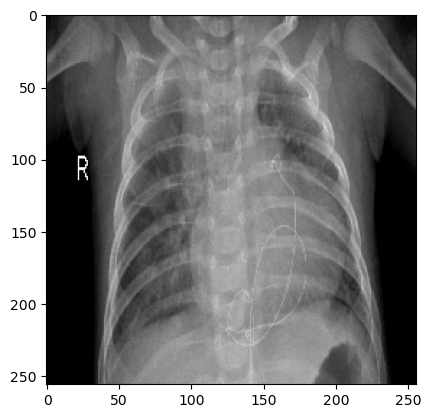

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


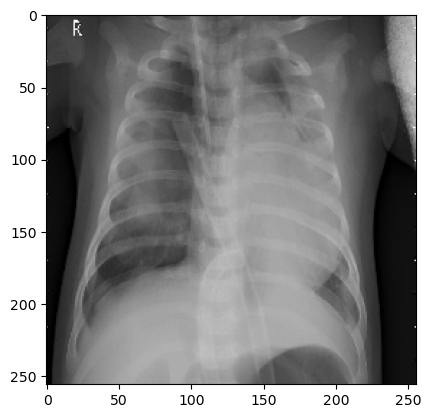

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


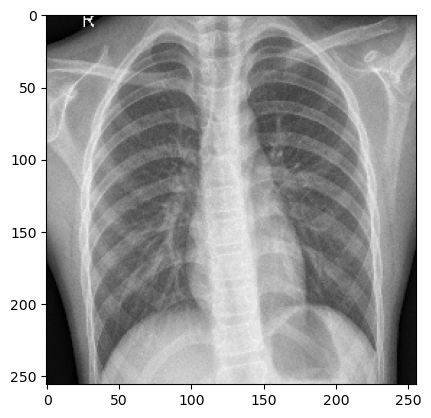

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : NORMAL


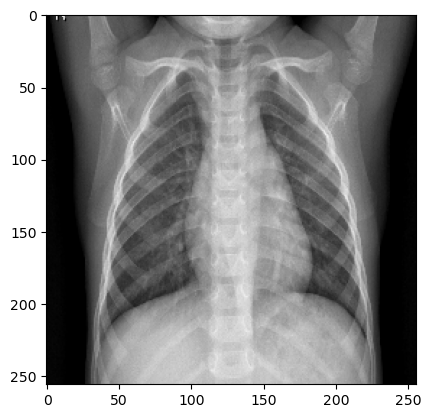

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : NORMAL


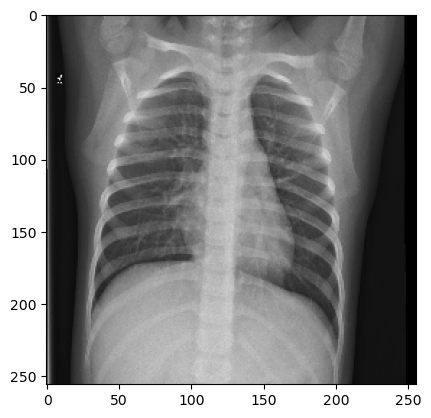

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : NORMAL


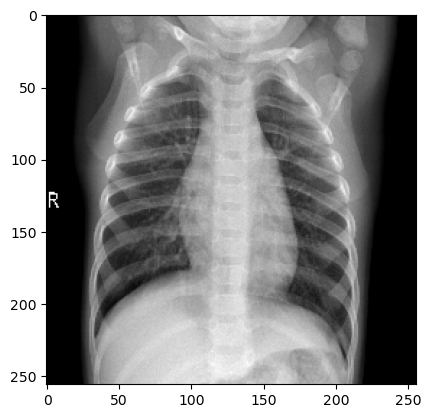

The prediction related to this image is :  NORMAL
 The true label of this image is : NORMAL


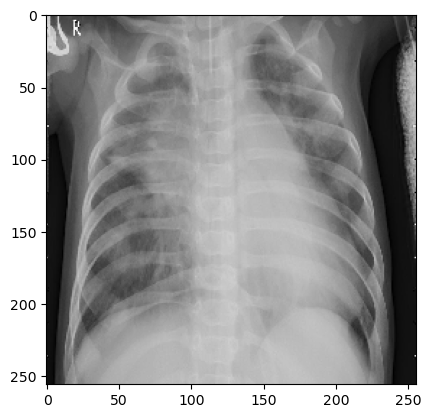

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


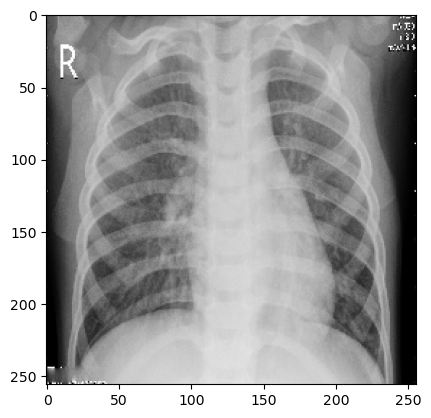

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


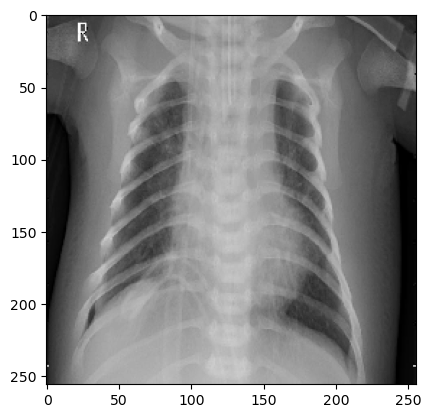

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


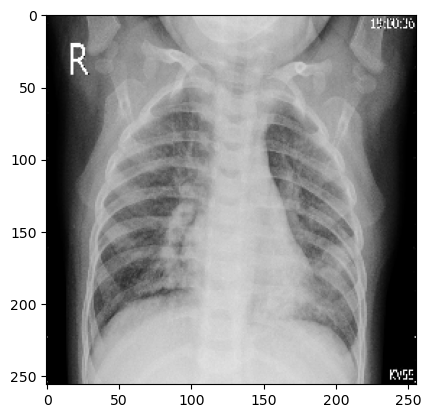

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


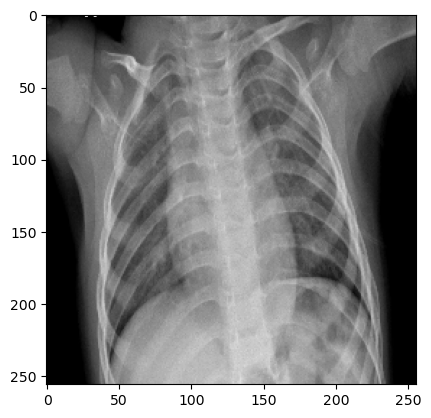

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : NORMAL


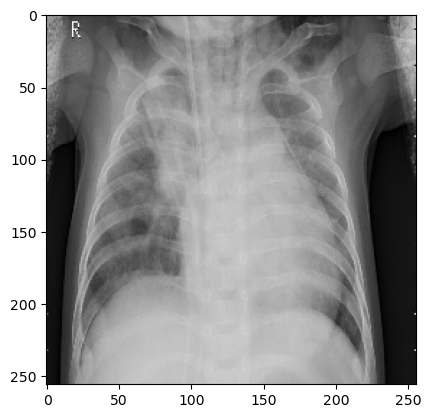

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


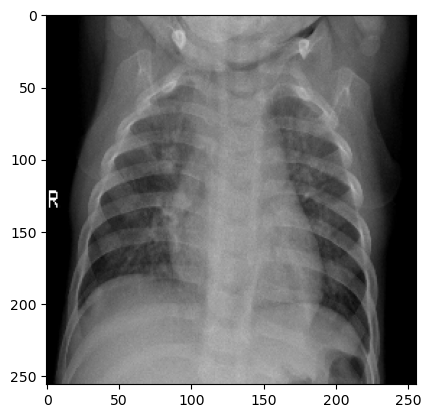

The prediction related to this image is :  NORMAL
 The true label of this image is : PNEUMONIA


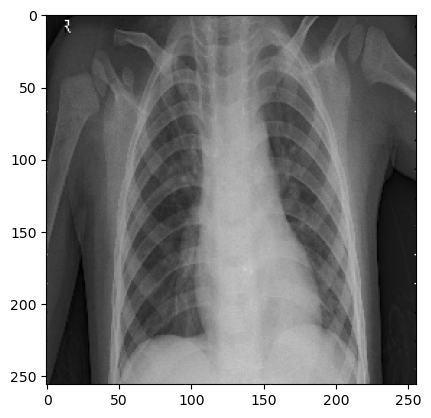

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


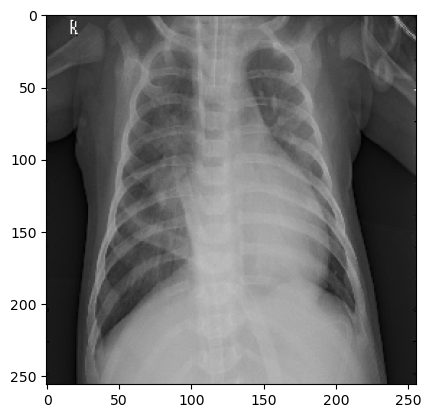

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


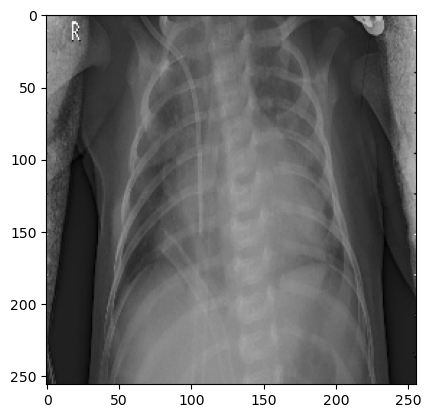

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


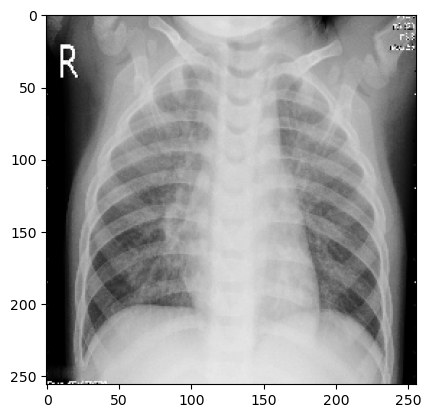

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


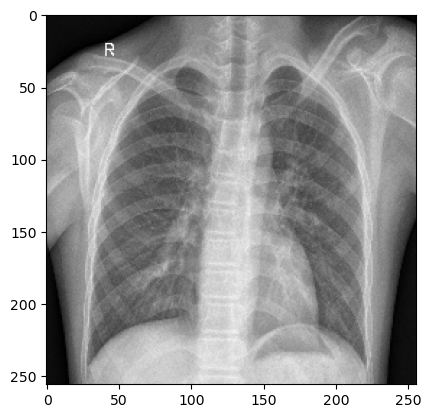

The prediction related to this image is :  NORMAL
 The true label of this image is : NORMAL


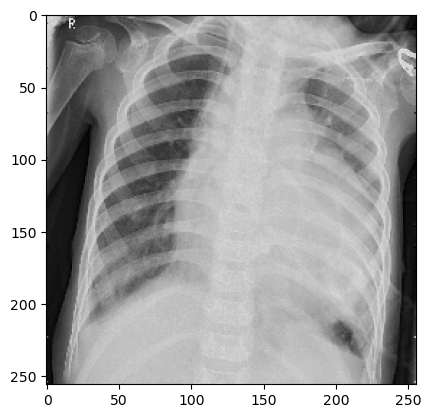

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


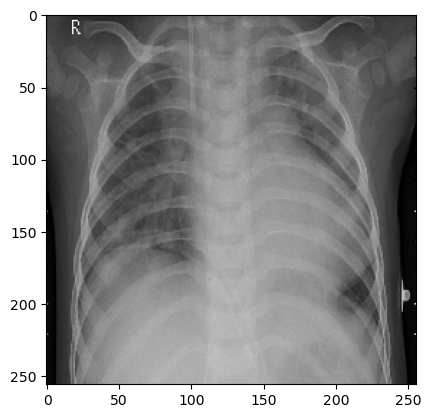

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


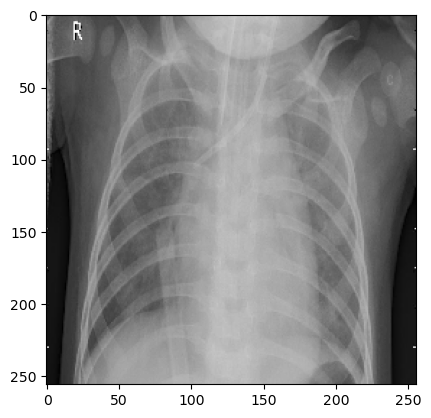

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


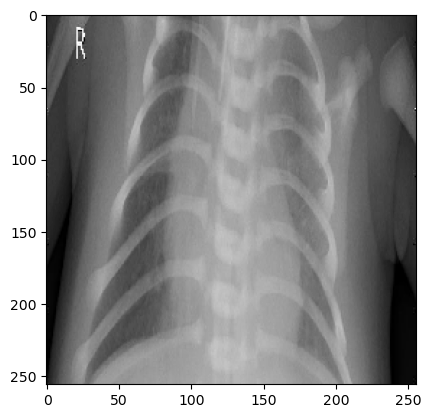

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


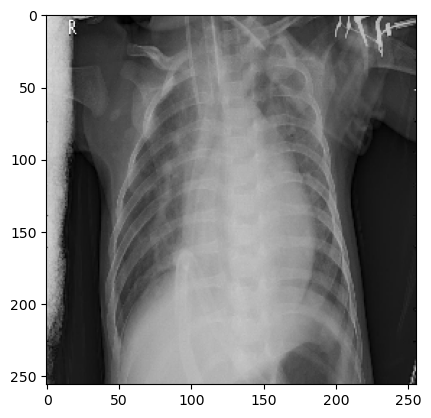

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


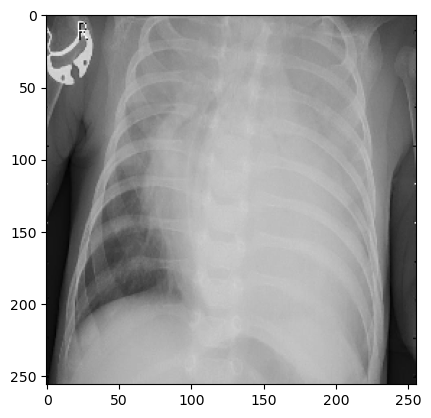

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


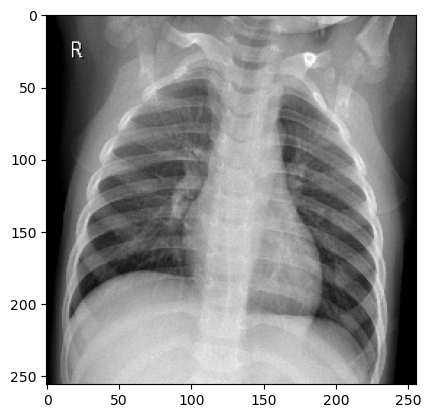

The prediction related to this image is :  NORMAL
 The true label of this image is : NORMAL


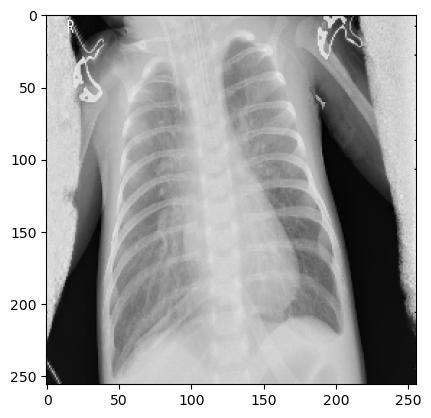

The prediction related to this image is :  PNEUMONIA
 The true label of this image is : PNEUMONIA


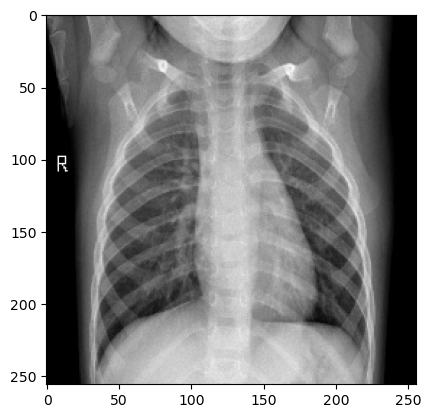

The prediction related to this image is :  NORMAL
 The true label of this image is : NORMAL


In [36]:
Im = data_test.next()
images = Im[0]
predictions2 = model.predict(images)
labels = Im[1]
classes = ["NORMAL", "PNEUMONIA"]
for j in range(len(images)):
    plt.imshow(images[j].squeeze(), cmap = "gray")
    plt.show()
    print("The prediction related to this image is : ", classes[np.argmax(predictions2[j])])
    print(" The true label of this image is :", classes[np.argmax(labels[j])])

### Perfomrance metrics

To develop an efficient classification model for pneumonia detection, it is important to minimize false negatives. A model that fails to detect all true pneumonia cases may incorrectly classify a sick patient as healthy, which can have serious consequences.

A good classification model should have:

**High recall** → Important to detect the maximum number of pneumonia cases.

**Decent precision** → To avoid too many false positives.

**Good F1-score** → A good balance between recall and precision.

In [ ]:
import tensorflow as tf

class Model_recall:
    def __init__(self, input_shape=(256, 256, 1), num_classes=2):

        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None  # Will be defined next

    def build_model(self):

        self.model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=self.input_shape),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(256, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(512, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(self.num_classes, activation="softmax")
        ])

    def summary(self):

        if self.model is not None:
            self.model.summary()
        else:
            raise ValueError("LModel is not built yet. Call `build_model()` first.")

    def fit(self, train_data, epochs, validation_data=None):

        if self.model is None:
            raise ValueError("Model is not built yet. Call `build_model()` first.")
        
        self.model.compile(
            optimizer="adam",
            loss="binary_crossentropy ",
            metrics=[tf.keras.metrics.Recall()]
        )
        
        history = self.model.fit(
            train_data,
            epochs=epochs,
            validation_data=validation_data
        )
        return history
    
    def evaluate(self, test_data):

        if self.model is None:
            raise ValueError("Le modèle n'a pas encore été construit. Appelez `build_model()` en premier.")

        loss, recall = self.model.evaluate(test_data)
        print(f"Test Loss: {loss:.4f}")
        print(f"Test Accuracy: {recall:.4f}")
        return loss, recall
    
    def predict(self, test_data):

        if self.model is None:
            raise ValueError("Le modèle n'a pas encore été construit. Appelez `build_model()` en premier.")

        predictions = self.model.predict(test_data)
        print(f"Prediction is : {predictions}")
        return predictions